In [1]:
import numpy as np
import warnings
from scipy import linalg
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.patches import Rectangle
plt.rcParams["animation.html"] = "jshtml"

In [13]:
def make_system(Kp=70, Ki=20, Kd=1, Ks=9, dt=0.02, Tend=18, L=None, N1=10):
    """
    Creates a multi-agent system model with PI control for leader-follower consensus.

    This function defines a multi-agent system with leader-follower behavior governed by
    proportional-integral (PI) control laws. It generates the state-space matrices (`Abar`,
    `Bbar`, `Cbar`, and `Dbar`) for the augmented system, along with the simulation
    time horizon (`T`), initial state (`X0`), and sampling time step (`dt`).

    Args:
        Kp (float, optional): Proportional control gain. Defaults to 70.
        Ki (float, optional): Integral control gain. Defaults to 20.
        Kd (float, optional): Derivative control gain (not used in this implementation). Defaults to 1.
        Ks (float, optional): Scaling factor for controller gains. Defaults to 9.
        dt (float, optional): Sampling time step for the simulation. Defaults to 0.02 seconds.
        Tend (float, optional): End time for the simulation. Defaults to 18 seconds.
        L (np.ndarray, optional): Laplacian matrix describing agent communication (if None, a default is created).
        N1 (int, optional): Number of agents in the system. Defaults to 10.

    Returns:
        tuple: A tuple containing the following elements:
            - Abar (np.ndarray): Augmented state matrix.
            - Bbar (np.ndarray): Augmented input matrix.
            - Cbar (np.ndarray): Augmented output matrix.
            - Dbar (np.ndarray): Augmented feedthrough matrix.
            - T (np.ndarray): Array of time steps for the simulation.
            - X0 (np.ndarray): Initial state vector for the system.
            - dt (float): Sampling time step.
    """

    T = np.arange(0, Tend + dt, dt)
    kI1=Ki            # kI=5
    kP1=Kp   # Replace with the desired value for kP1
    ks = 9
    c = 200  # Replace with the desired value for c
    m = 1000  # Replace with the desired value for m
    r = 1
    kI=kI1*ks
    kP=kP1*ks

    alpha = 0.1
    A = np.array([[-c / m, kI1 * ks / m], [0, 0]])
    B = np.array([[kP1 * ks / m], [Kd]])
    C = np.array([[1, 0]])
    D = 0
    X0 = np.zeros((1,2))

    if L is None:
        G_adj = np.tril(np.ones((N1, N1)), -1)
        L = np.diag(G_adj.sum(axis=1)) - G_adj
    # Normalize communication matrix
    L_norm = np.zeros((N1, N1))
    for k1 in range(N1):
        if L[k1, k1] != 0:
            for k2 in range(N1):
                L_norm[k1, k2] = L[k1, k2] / L[k1, k1]
    # L_norm = L
    # Augmented state-space matrices (consider using control system libraries for efficiency)
    Abar = np.kron(np.eye(N1), A) - np.kron(L_norm, np.dot(B, C))
    # Abar = np.kron(np.diag(np.ones(N1)), A) - np.kron(L_norm, B @ C)
    Bbar = np.zeros((N1 * 2, 1))
    Cbar = np.kron(np.eye(N1), C)
    Dbar = np.zeros((N1, 1))

    # Initial states
    v0 = np.ones(N1) * 5
    v0[0] = 10
    X0 = np.zeros(2 * N1)
    if (Kp == 0) and (Ki == 0):
        X0[1::2] = np.arange(N1)[::-1]
        X0[::2] = 5
        X0[0] = 10
    else:
        for k1 in range(N1):
            X0[2 * k1] = v0[k1]
            # X0[2 * k1 + 1] = c / kI * v0[k1]
            X0[2 * k1 + 1] = -0.8*k1 + (c / kI * v0[k1])

    return Abar, Bbar, Cbar, Dbar, T, X0, dt


In [3]:
def sim_collision(Abar, Bbar, Cbar, T, X0, U, collide_at=700, collision_factor=0.0, dt=0.02):
    """
    Simulates a linear system with a collision event.

    This function simulates the behavior of a linear system defined by state-space matrices
    `Abar`, `Bbar`, and `Cbar` over a time horizon specified by `T` with initial state `X0`
    and input sequence `U`. It introduces a collision event at a specific time step
    (`collide_at`) that modifies the system's state according to a scaling factor
    (`collision_factor`).

    Args:
        Abar (np.ndarray): State matrix of the system.
        Bbar (np.ndarray): Input matrix of the system.
        Cbar (np.ndarray): Output matrix of the system.
        T (np.ndarray): Array of time steps for the simulation.
        X0 (np.ndarray): Initial state of the system.
        U (np.ndarray): Array of input values for each time step.
        collide_at (int, optional): Time step at which the collision occurs. Defaults to 700.
        collision_factor (float, optional): Factor by which to scale the system state after the collision. Defaults to 0.0 (no change).
        dt (float, optional): Sampling time step for the simulation. Defaults to 0.02 seconds.

    Returns:
        np.ndarray: Array of system outputs for each time step.
    """
    n_states = Abar.shape[0]
    n_inputs = Bbar.shape[1]
    n_outputs = Cbar.shape[0]
    n_steps = T.shape[0]
    # U[:,0] = 1
    xout = np.zeros((n_states, n_steps))
    # print(xout.shape)
    xout[:, 0] = X0 
    yout = np.zeros((n_outputs, n_steps))
    M = np.block([[Abar * dt, Bbar * dt, np.zeros((n_states, n_inputs))],
                    [np.zeros((n_inputs, n_states + n_inputs)),
                    np.identity(n_inputs)],
                    [np.zeros((n_inputs, n_states + 2 * n_inputs))]])
    expM = linalg.expm(M)
    Ad = expM[:n_states, :n_states]
    Bd1 = expM[:n_states, n_states+n_inputs:]
    Bd0 = expM[:n_states, n_states:n_states + n_inputs] - Bd1
    for i in range(1, n_steps):
        if i >= collide_at:
            xout[0,i-1] *= collision_factor 
        xout[:, i] = (Ad @ xout[:, i-1]
                        + Bd0 @ U[:, i-1] + Bd1 @ U[:, i])
    yout = Cbar @ xout

    return yout

In [4]:
def make_animation(positions, dt=0.02, xlim=None, title="With PI Controller and Custom L"):
    """
    Creates an animation of a moving object based on position data.

    This function takes a NumPy array `positions` containing the object's position
    over time and generates an animation using Matplotlib's animation capabilities.
    Each row in `positions` represents the position at a specific time step.

    Args:
        positions (np.ndarray): Array of positions over time. Each row represents
            the position at a specific time step (x, y coordinates).
        dt (float, optional): Sampling time step between position data points. Defaults to 0.02 seconds.
        xlim (str, optional): List defining the x-axis limits for the animation. Defaults to None,
            which will automatically calculate the limits based on the data.
        title (str, optional): Title for the animation plot. Defaults to "With PI Controller and Custom L".

    Returns:
        matplotlib.animation.FuncAnimation: The created animation object.
    """

    fig, ax = plt.subplots()

    scat = ax.scatter(0, 0, c="b", s=5)
    if xlim is None:
        xlim = [int(positions.min()) - 1, int(positions[:, 0].max()) + 1]
        ax.set(xlim=xlim)
    ax.set(ylim=[-0.01, 0.01], xlabel='Position [m]')
    ax.set_title(title)
    # ax.set(xlim=[-2, 400], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
    ax.legend()
    N = positions.shape[1]
    car_colors = plt.cm.viridis(np.linspace(0, 1, N))
    CAR_WIDTH = 4
    CAR_HEIGHT = 2
    def update(frame):
        # for each frame, update  the data stored on each artist.
        y = positions[frame,:].T
        
        i = 0
        # update the scatter plot:
        data = np.stack([y, [0.0]*N]).T
        scat.set_offsets(data)
        scat.set_sizes([25.0]*N)
        # scat.set_capstyle
        scat.set_facecolors(car_colors)
        scat.set_label("Time: %.2f s"%(frame*dt))
        ax.legend()
        if xlim == 'zoom':
            ax.set(xlim=[y.min() - 1, y.max() + 3])
        return scat


    ani = animation.FuncAnimation(fig=fig, func=update, frames=positions.shape[0], interval=30)
    plt.close()
    return ani 

## Time Headway simulation.

In [5]:
T0 = 1.5 
T1 = 2 
T2 = 2.5 
T3 = 3 
T4 = 2 
T5 = 3.5 
A0 = np.array([[-1/T0, 0], [ 1, 0]]) 
B0 = np.array([[1/T0],  [0]]) 
A1 = np.array([[-1/T1, 0], [ 1, 0]])
B1 = np.array([[1/T1],  [0]]) 
A2 = np.array([[-1/T2, 0],  [1, 0]] )
B2 = np.array([[1/T2],  [0]]) 
A3 = np.array([[-1/T3, 0],  [1, 0]]) 
B3 = np.array([[1/T3],  [0]]) 
A4 = np.array([[-1/T4, 0],  [1, 0]]) 
B4 = np.array([[1/T4],  [0]]) 
A5 = np.array([[-1/T5, 0],  [1, 0]]) 
B5 = np.array([[1/T5],  [0]]) 
C = np.array([[0, 1]]) 
Cz = np.array([[1, 0]]) 
n = 2 

In [6]:
## Make the system Matrices.

Null = np.zeros((n,n))
AbarACC = np.block([[A0, Null, Null, Null, Null, Null],
                    [B1@Cz, A1, Null, Null, Null, Null],
                    [Null, B2@Cz, A2, Null, Null, Null],
                    [Null, Null, B3@Cz, A3, Null, Null],
                    [Null, Null, Null, B4@Cz, A4, Null],
                    [Null, Null, Null, Null, B5@Cz, A5]
                    ])
N1 = 6
Bbar = np.vstack([B0, np.zeros(((N1-1)*n, 1))])

Cv = np.kron(np.eye(N1), Cz)
diag_ones = np.diag(np.ones(N1-1), 1)
Cd = np.kron(np.eye(N1), C) - np.kron(diag_ones, C)
Cs = np.kron(np.eye(N1), C)

In [7]:
beta=2    # time-headway coefficient
alpha=1
v0=0
v1=20

si=alpha + beta*v0    # initial spacing
x0= np.array([v0,  0,  v0,  -si,  v0,  -2*si,  v0,  -3*si,  v0,  -4*si,  v0,  -5*si])
dt = 0.02  # Sampling time (seconds)
Tv0 = 0     # Start time of event 0 (seconds)
Tv1 = 3     # Start time of event 1 (seconds)
Tv2 = 12    # Start time of event 2 (seconds)
Tv3 = 20    # Start time of event 3 (seconds)
Tend = 45   # End time of simulation (seconds)

# Calculate end indices for each event (inclusive)
k0e = int(Tv0 / dt)  # Zero-based indexing in Python
k1e = int(Tv1 / dt)
k2e = int(Tv2 / dt)
k3e = int(Tv3 / dt)
k4e = int(Tend / dt)
TimeW = np.arange(0, (k4e-1)*dt + dt, dt)

# User Defined input.
W=v0+v1*np.block([[0*np.ones((k1e-k0e,1))], 
                [0.9*np.ones((k2e-k1e,1))],  
                [0.3*np.ones((k3e-k2e,1))],  
                [0.6*np.ones((k4e-k3e+1,1))]])

In [8]:
velocity = sim_collision(AbarACC, Bbar, Cv, TimeW, x0, W.T, collide_at=99999, collision_factor=0, dt=dt)
distance = sim_collision(AbarACC, Bbar, Cd, TimeW, x0, W.T, collide_at=99999, collision_factor=0, dt=dt)

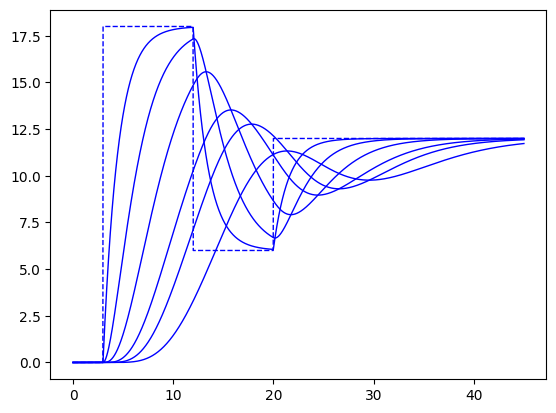

In [9]:
plt.plot(TimeW, velocity.T, c="blue", linewidth=1)
plt.plot(TimeW, W, 'b--', linewidth=1)

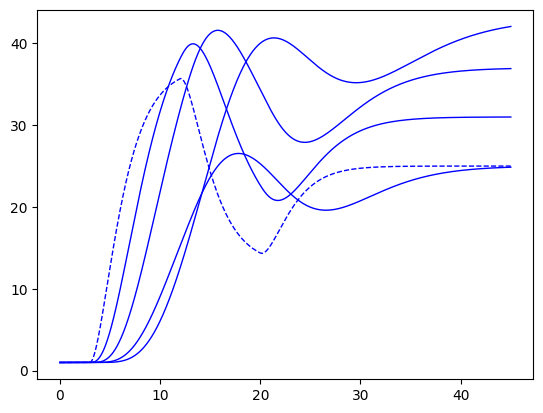

In [10]:
plt.plot(TimeW, distance[0].T, 'b--', linewidth=1)
plt.plot(TimeW, distance[1:-1].T, c='blue', linewidth=1)

In [11]:
positions = np.cumsum(velocity.reshape(N1,-1), axis=1).T*dt + x0[1::2]

In [12]:
ani = make_animation(positions, dt=dt, xlim='zoom', title="Simulation")
ani.save("headway_ani.gif")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter ffmpeg unavailable; using Pillow instead.
